# Evaluation of the 0D validation plate (exp100/JG405)

We have previously made predictions for this plate and now have obtained the analytical data.
We want to evaluate how well our predictions align with the experiment.

The plate was originally designed using the model trained on 2023-09-05 data and it was designed such that all attempted syntheses were predicted to work by the model. In the meantime we had to make minor changes in the data and retrain on the updated 2023-12-20 data. While the predictions of the two models align well (ca. 97% accuracy across the VL across products), we need to account for the differences.

There is no completely unbiased way to do this. The best is to just drop all of the cases where the new model predicts a negative value and evaluate the precision based on the remaining values. This is slightly biased because the compounds were "pre-selected" by the earlier model. Fortunately the influence of this will be small since the models align so well.

In [21]:
import pathlib
import sys

sys.path.append(str(pathlib.Path().resolve().parents[1]))

import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, accuracy_score

from src.definitions import DATA_DIR
from src.util.db_utils import SynFermDatabaseConnection

In [22]:
preds = pd.read_csv(DATA_DIR / "curated_data" / "validation-plate_candidates_predictions_2023-12-20.csv")
preds.head()

,vl_id,long_name,product_A_smiles,reaction_smiles_atom_mapped,prob_A,prob_B,prob_C,pred_A,pred_B,pred_C
0,224342,Ph031 + Spiro013 + TerTH016,COc1ccccc1-c1nnc(CC2(NC(=O)c3ccc(C4=NCCO4)cc3)...,F[B-](F)(F)[C:1](=[O:2])[c:11]1[cH:12][cH:14][...,0.999998,0.999971,0.727206,1,1,1
1,224328,Ph031 + Spiro013 + TerABT022,CCOc1ccc2nc(CC3(NC(=O)c4ccc(C5=NCCO5)cc4)CN(C(...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,0.985645,0.029104,0.004056,1,0,0
2,224321,Ph031 + Spiro013 + TerABT012,O=C(NC1(Cc2nc3cc(Cl)ccc3s2)CN(C(=O)O[C@H]2CCOC...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,0.333029,0.114547,0.002028,0,0,0
3,224341,Ph031 + Spiro013 + TerTH015,O=C(NC1(Cc2nnc(-c3cc(Cl)cc(Cl)c3)s2)CN(C(=O)O[...,F[B-](F)(F)[C:1](=[O:2])[c:11]1[cH:12][cH:14][...,0.999727,0.999878,0.046494,1,1,0
4,224351,Ph031 + Spiro013 + TerTH027,O=C(NC1(Cc2nnc(-c3ccc4[nH]nnc4c3)s2)CN(C(=O)O[...,F[B-](F)(F)[C:1](=[O:2])[c:11]1[cH:12][cH:14][...,0.999959,0.999878,0.177345,1,1,0


In [24]:
con = SynFermDatabaseConnection()

In [25]:
res = con.con.execute("SELECT id, vl_id, well, initiator_long, monomer_long, terminator_long, product_A_lcms_ratio, product_B_lcms_ratio, product_C_lcms_ratio FROM experiments WHERE exp_nr = 100 AND (valid NOT LIKE 'ERROR%' OR valid IS NULL);").fetchall()
result = pd.DataFrame(res, columns=["id", "vl_id", "well", "initiator_long", "monomer_long", "terminator_long", "product_A_lcms_ratio", "product_B_lcms_ratio", "product_C_lcms_ratio"])
result["binary_A"] = (result["product_A_lcms_ratio"] > 0).astype(int)
result["binary_B"] = (result["product_B_lcms_ratio"] > 0).astype(int)
result["binary_C"] = (result["product_C_lcms_ratio"] > 0).astype(int)
result.head()

,id,vl_id,well,initiator_long,monomer_long,terminator_long,product_A_lcms_ratio,product_B_lcms_ratio,product_C_lcms_ratio,binary_A,binary_B,binary_C
0,88994,221911,A10,Ph031,Mon003,TerTH001,0.167212,0.145223,0.000475,1,1,1
1,88995,106262,A11,BiAl008,Fused005,TerTH016,0.377146,0.065183,0.266628,1,1,1
2,88996,108268,A12,BiAl008,Mon097,TerTH013,0.177339,0.268945,0.059126,1,1,1
3,89007,179066,A3,Ph013,Fused005,TerTH001,0.230543,0.232324,0.002596,1,1,1
4,89008,91449,A4,Al013,Mon003,TerTH001,1.155263,0.288549,0.615973,1,1,1


In [26]:
len(result)

153

In [27]:
# combine predictions and results
comb = result.merge(preds, on="vl_id", how="left")
comb.head()

,id,vl_id,well,initiator_long,monomer_long,terminator_long,product_A_lcms_ratio,product_B_lcms_ratio,product_C_lcms_ratio,binary_A,...,binary_C,long_name,product_A_smiles,reaction_smiles_atom_mapped,prob_A,prob_B,prob_C,pred_A,pred_B,pred_C
0,88994,221911,A10,Ph031,Mon003,TerTH001,0.167212,0.145223,0.000475,1,...,1,Ph031 + Mon003 + TerTH001,CC(C)C[C@@H](Cc1nnc(-c2ccccc2)s1)NC(=O)c1ccc(C...,F[B-](F)(F)[C:1](=[O:2])[c:11]1[cH:12][cH:14][...,0.999990,0.999992,0.205542,1,1,0
1,88995,106262,A11,BiAl008,Fused005,TerTH016,0.377146,0.065183,0.266628,1,...,1,BiAl008 + Fused005 + TerTH016,COC(=O)NCCCCC(=O)N[C@H]1CN(C(=O)OCc2ccccc2)C[C...,F[B-](F)(F)[C:1](=[O:2])[CH2:11][CH2:12][CH2:1...,0.999939,0.999690,0.999848,1,1,1
2,88996,108268,A12,BiAl008,Mon097,TerTH013,0.177339,0.268945,0.059126,1,...,1,BiAl008 + Mon097 + TerTH013,COC(=O)NCCCCC(=O)N[C@@H](Cc1nnc(-c2ccc(C(F)(F)...,F[B-](F)(F)[C:1](=[O:2])[CH2:11][CH2:12][CH2:1...,0.999999,0.999994,0.948263,1,1,1
3,89007,179066,A3,Ph013,Fused005,TerTH001,0.230543,0.232324,0.002596,1,...,1,Ph013 + Fused005 + TerTH001,CC(C)(C)OC(=O)Nc1ccc(C(=O)N[C@H]2CN(C(=O)OCc3c...,F[B-](F)(F)[C:1](=[O:2])[c:11]1[cH:12][cH:14][...,0.999867,0.997366,0.741841,1,1,1
4,89008,91449,A4,Al013,Mon003,TerTH001,1.155263,0.288549,0.615973,1,...,1,Al013 + Mon003 + TerTH001,CCCCCCCCC(=O)N[C@H](Cc1nnc(-c2ccccc2)s1)CC(C)C,F[B-](F)(F)[C:1](=[O:2])[CH2:11][CH2:12][CH2:1...,0.991691,0.999501,0.998680,1,1,1


In [28]:
# are there any compounds that the new model would not have predicted to work?
comb.loc[comb["pred_A"] == 0]

,id,vl_id,well,initiator_long,monomer_long,terminator_long,product_A_lcms_ratio,product_B_lcms_ratio,product_C_lcms_ratio,binary_A,...,binary_C,long_name,product_A_smiles,reaction_smiles_atom_mapped,prob_A,prob_B,prob_C,pred_A,pred_B,pred_C
22,89048,94042,C4,Al013,Spiro017,TerTH014,0.006011,0.00000,1.120595,1,...,1,Al013 + Spiro017 + TerTH014,CCCCCCCCC(=O)N[C@]1(Cc2nnc(-c3cccc([N+](=O)[O-...,F[B-](F)(F)[C:1](=[O:2])[CH2:11][CH2:12][CH2:1...,0.549312,0.779729,0.997211,0,1,1
105,89214,197185,L10,Ph021,Spiro017,TerABT018,0.002750,0.00149,0.000623,1,...,1,Ph021 + Spiro017 + TerABT018,O=C(N[C@]1(Cc2nc3c(F)cc(F)cc3s2)CCCOC1)c1ccc(F...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,0.418977,0.638711,0.009563,0,1,0


### Side note on bias through model update
Turns out there are only 2/153 instances where the two models disagree. (Curiously enough, the probability is almost exactly at the decision threshold). In any case, we drop these two data points before we continue the analysis

In [29]:
comb = comb.loc[comb["pred_A"] == 1]
len(comb)

151

In [30]:
# Evaluate for binary_A: What was the models prospective precision?
len(comb.loc[comb["binary_A"] == 1]) / len(comb)

0.9801324503311258

In [31]:
# evaluate for binary_B
print(f'Accuracy: {accuracy_score(comb["binary_B"], comb["pred_B"]):.2%}')
print(f'Precision: {precision_score(comb["binary_B"], comb["pred_B"]):.2%}')
print(f'Recall: {recall_score(comb["binary_B"], comb["pred_B"]):.2%}')

Accuracy: 84.77%
Precision: 84.62%
Recall: 95.19%


In [32]:
# evaluate for binary_C
print(f'Accuracy: {accuracy_score(comb["binary_C"], comb["pred_C"]):.2%}')
print(f'Precision: {precision_score(comb["binary_C"], comb["pred_C"]):.2%}')
print(f'Recall: {recall_score(comb["binary_C"], comb["pred_C"]):.2%}')

Accuracy: 86.75%
Precision: 100.00%
Recall: 67.74%


In [33]:
# show the wells that had valid reactions in the plate layout
# n.b. we ignore the right half of the plate b/c all of that was invalid (oxalic acid transfer error)
arr = np.zeros((16, 10), dtype=int)

for well in comb["well"]:
    row = ord(well[0]) - 65
    col = int(well[1:]) - 3
    arr[row, col] = 1
arr

array([[1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 1, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

<Axes: >

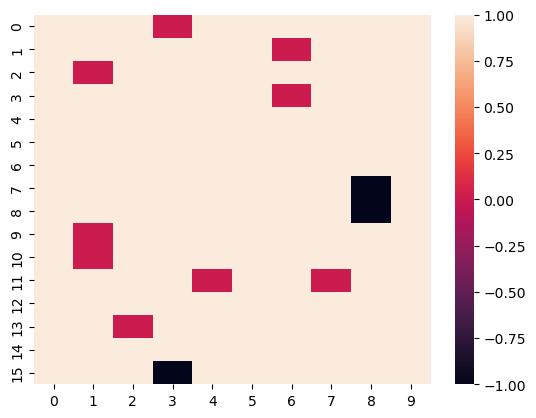

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(arr)

In [69]:
palette = sns.color_palette(["#e42536", "#f0f0f0", "#5790fc"])
palette

[(0.8941176470588236, 0.1450980392156863, 0.21176470588235294),
 (0.9411764705882353, 0.9411764705882353, 0.9411764705882353),
 (0.3411764705882353, 0.5647058823529412, 0.9882352941176471)]

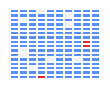

In [70]:
# where was A predicted correctly?
arr = np.zeros((16, 10), dtype=int)

for i, dfrow in comb.iterrows():
    row = ord(dfrow["well"][0]) - 65
    col = int(dfrow["well"][1:]) - 3
    if dfrow["pred_A"] == dfrow["binary_A"]:
        arr[row, col] = 1
    else:
        arr[row, col] = -1
plt.figure(figsize=(1.2, 1))
ax = sns.heatmap(arr, center=0, cmap=palette, cbar=False, linewidths=0.1)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.savefig("exp100_precisionA.svg", transparent=True)

<Axes: >

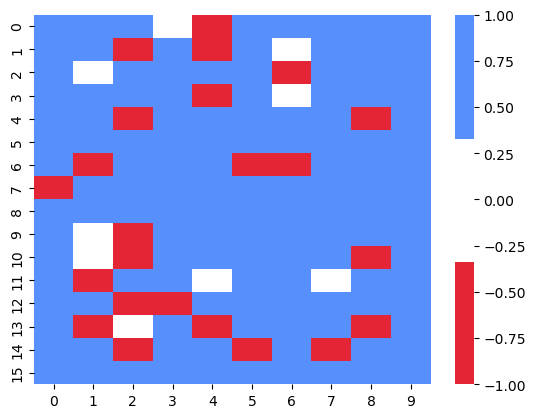

In [40]:
# where was B predicted correctly?
arr = np.zeros((16, 10), dtype=int)

for i, dfrow in comb.iterrows():
    row = ord(dfrow["well"][0]) - 65
    col = int(dfrow["well"][1:]) - 3
    if dfrow["pred_B"] == dfrow["binary_B"]:
        arr[row, col] = 1
    else:
        arr[row, col] = -1
sns.heatmap(arr, center=0, cmap=palette)

<Axes: >

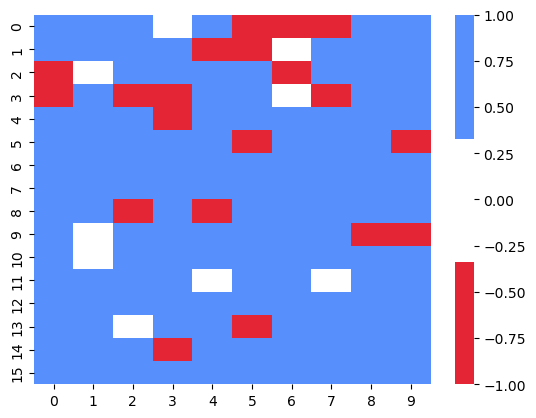

In [41]:
# where was C predicted correctly?
arr = np.zeros((16, 10), dtype=int)

for i, dfrow in comb.iterrows():
    row = ord(dfrow["well"][0]) - 65
    col = int(dfrow["well"][1:]) - 3
    if dfrow["pred_C"] == dfrow["binary_C"]:
        arr[row, col] = 1
    else:
        arr[row, col] = -1
sns.heatmap(arr, center=0, cmap=palette)